In [0]:
!cat /etc/issue

In [0]:
!cat /proc/driver/nvidia/gpus/0000:00:04.0/information

/bin/bash: conda: command not found


#Fazer




*   confuzin and matrix = print(classification_report())
*   SKLearning para avaliar, matrix confuzion e tals
*   Voltar para 3 classes
*   mudar para sgd
*   CheXnet
*   Arrumar imagens dataset covid
*   bin ou mult???
*   augmentation in train and val
*   testar sigmoid
*   binary crossentropy

***Mudar agora***
- Tratar com binário
- binary_crossentropy
- sigmopid na ultima

- testar 30,30,30
- mudar monitor[acc]





#Feito

*   ***inicialzar pesos do kernel em todos os modelos = top_model = Dense(1024,activation='relu', kernel_initializate='he_normal')(top_model)***
*   ***re-treinar as camadas das redes pre treinadas***
*   ***arrumar dropout 0.5***
*   ***dataimagegeneration***
*   ***ReduceLROnPlateau***
*   ***usar DenseNet121***
*   ***Mudar dataset para o do kaggle mais atual***

#Imports

In [1]:
version = '-v9-'

In [1]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

Using TensorFlow backend.


In [2]:
tf.__version__

'2.3.0'

In [3]:
data_dir = '/home/jimi/dissertacao/covid19/datasets/80-20/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'



/home/jimi/dissertacao/covid19/dataset/dataset_final/
/home/jimi/dissertacao/covid19/dataset/dataset_final/normal/
/home/jimi/dissertacao/covid19/dataset/dataset_final/pneumonia/
/home/jimi/dissertacao/covid19/dataset/dataset_final/covid/


#Download do dataset no kaggle

In [0]:
%%shell

export KAGGLE_USERNAME=jimitogni
export KAGGLE_KEY=aea778a52ae308a26e4ad5dad779ada9

kaggle datasets download tawsifurrahman/covid19-radiography-database


100% 1.15G/1.15G [00:09<00:00, 125MB/s]
100% 1.15G/1.15G [00:09<00:00, 126MB/s]


In [0]:
print ("normal no ds final: ", len([iq for iq in os.scandir(path_to_images+)]))
print ("normal no reopo: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/COVID-19 Radiography Database/NORMAL')]))
print ("pneumonia ds: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/dataset/pneumonia/Viral Pneumonia')]))
print ("pneumonia repo: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/COVID-19 Radiography Database/Viral Pneumonia')]))print ("covid ds: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/dataset/covid')]))
print ("covid repo: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/COVID-19 Radiography Database/COVID-19')]))

print ("normal no ds final: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/dataset/normal/NORMAL')]))
print ("normal no reopo: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/COVID-19 Radiography Database/NORMAL')]))
print ("pneumonia ds: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/dataset/pneumonia/Viral Pneumonia')]))
print ("pneumonia repo: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/COVID-19 Radiography Database/Viral Pneumonia')]))
print ("covid ds: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/dataset/covid')]))
print ("covid repo: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/COVID-19 Radiography Database/COVID-19')]))

SyntaxError: ignored

#Constantes

In [141]:
#parameters
num_classes = 3
img_rows, img_cols = 224, 224

epochs = 100
batch_size = 16

models_loss = 'binary_crossentropy'
models_opt = Adam(lr=0.001) #SGD(learning_rate=0.001, momentum=0.9) #ADAM(lr=0.001)

#Split dataset in train, test and *validation*

In [ ]:
# Path to data
data_dir = '/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'


# print("Datasets: {} - tamanho {}".format(os.listdir(data_dir), len(data_dir)))
# print("Imagens para treino: {}".format(len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/train')])))
# print("Imagens para teste: {}".format(len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/test')])))
# print("Imagens para validação: {}".format(len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/val')])))

len_covid = len([iq for iq in os.scandir(normal_dir)])
len_normal = len([iq for iq in os.scandir(pneumonia_dir)])
len_pneumonia = len([iq for iq in os.scandir(covid_dir)])

# len_test_covid = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/test/covid')])
# len_test_normal = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/test/normal')])
# len_val_covid = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/val/covid')])
# len_val_normal = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/val/normal')])

print('Files per classes')
print("----"*10)
print("normal : ", len_covid)
print("pneumonia : ", len_normal)
print("covid : ", len_pneumonia)


In [104]:
#dataaug

import numpy as np
import keras
import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os

datagen = ImageDataGenerator(rotation_range=20, 
                             width_shift_range = 0, 
                             height_shift_range = 0,  
                             shear_range=0, 
                             horizontal_flip = True,) 

imgs = os.listdir(normal_dir)

for img in imgs:
    img=cv2.imread(normal_dir+"/"+img)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    for batch in datagen.flow (x, batch_size=1, save_to_dir = r'/content/drive/My Drive/UNICAMP/databases/covid_aug2/normal', save_prefix ='aug', save_format='jpg'):
        print("numero de imagens geradas: ", i)
        i+=1
        if i>7:
            break

KeyboardInterrupt: 

In [ ]:
#dataaug
import numpy as np
import keras
import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os

datagen = ImageDataGenerator(rotation_range=20, 
                             width_shift_range = 0, 
                             height_shift_range = 0,  
                             shear_range=0, 
                             horizontal_flip = True,) 

imgs = os.listdir(pneumonia_dir)

for img in imgs:
    img=cv2.imread(pneumonia_dir+"/"+img)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    c = 0
    for batch in datagen.flow (x, batch_size=1, save_to_dir = r'/content/drive/My Drive/UNICAMP/databases/covid_aug2/normal', save_prefix ='aug', save_format='jpg'):
        print("numero de imagens geradas: ", c)
        i+=1
        c++
        if i>7:
            break

In [ ]:
#dataaug
import numpy as np
import keras
import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os

datagen = ImageDataGenerator(rotation_range=20, 
                             width_shift_range = 0, 
                             height_shift_range = 0,  
                             shear_range=0, 
                             horizontal_flip = True,) 
imgs = os.listdir(covid_dir)

for img in imgs:
    img=cv2.imread(covid_dir+"/"+img)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    for batch in datagen.flow (x, batch_size=1, save_to_dir = r'/content/drive/My Drive/UNICAMP/databases/covid_aug2/normal', save_prefix ='aug', save_format='jpg'):
        print("numero de imagens geradas: ", i)
        i+=1
        if i>7:
            break

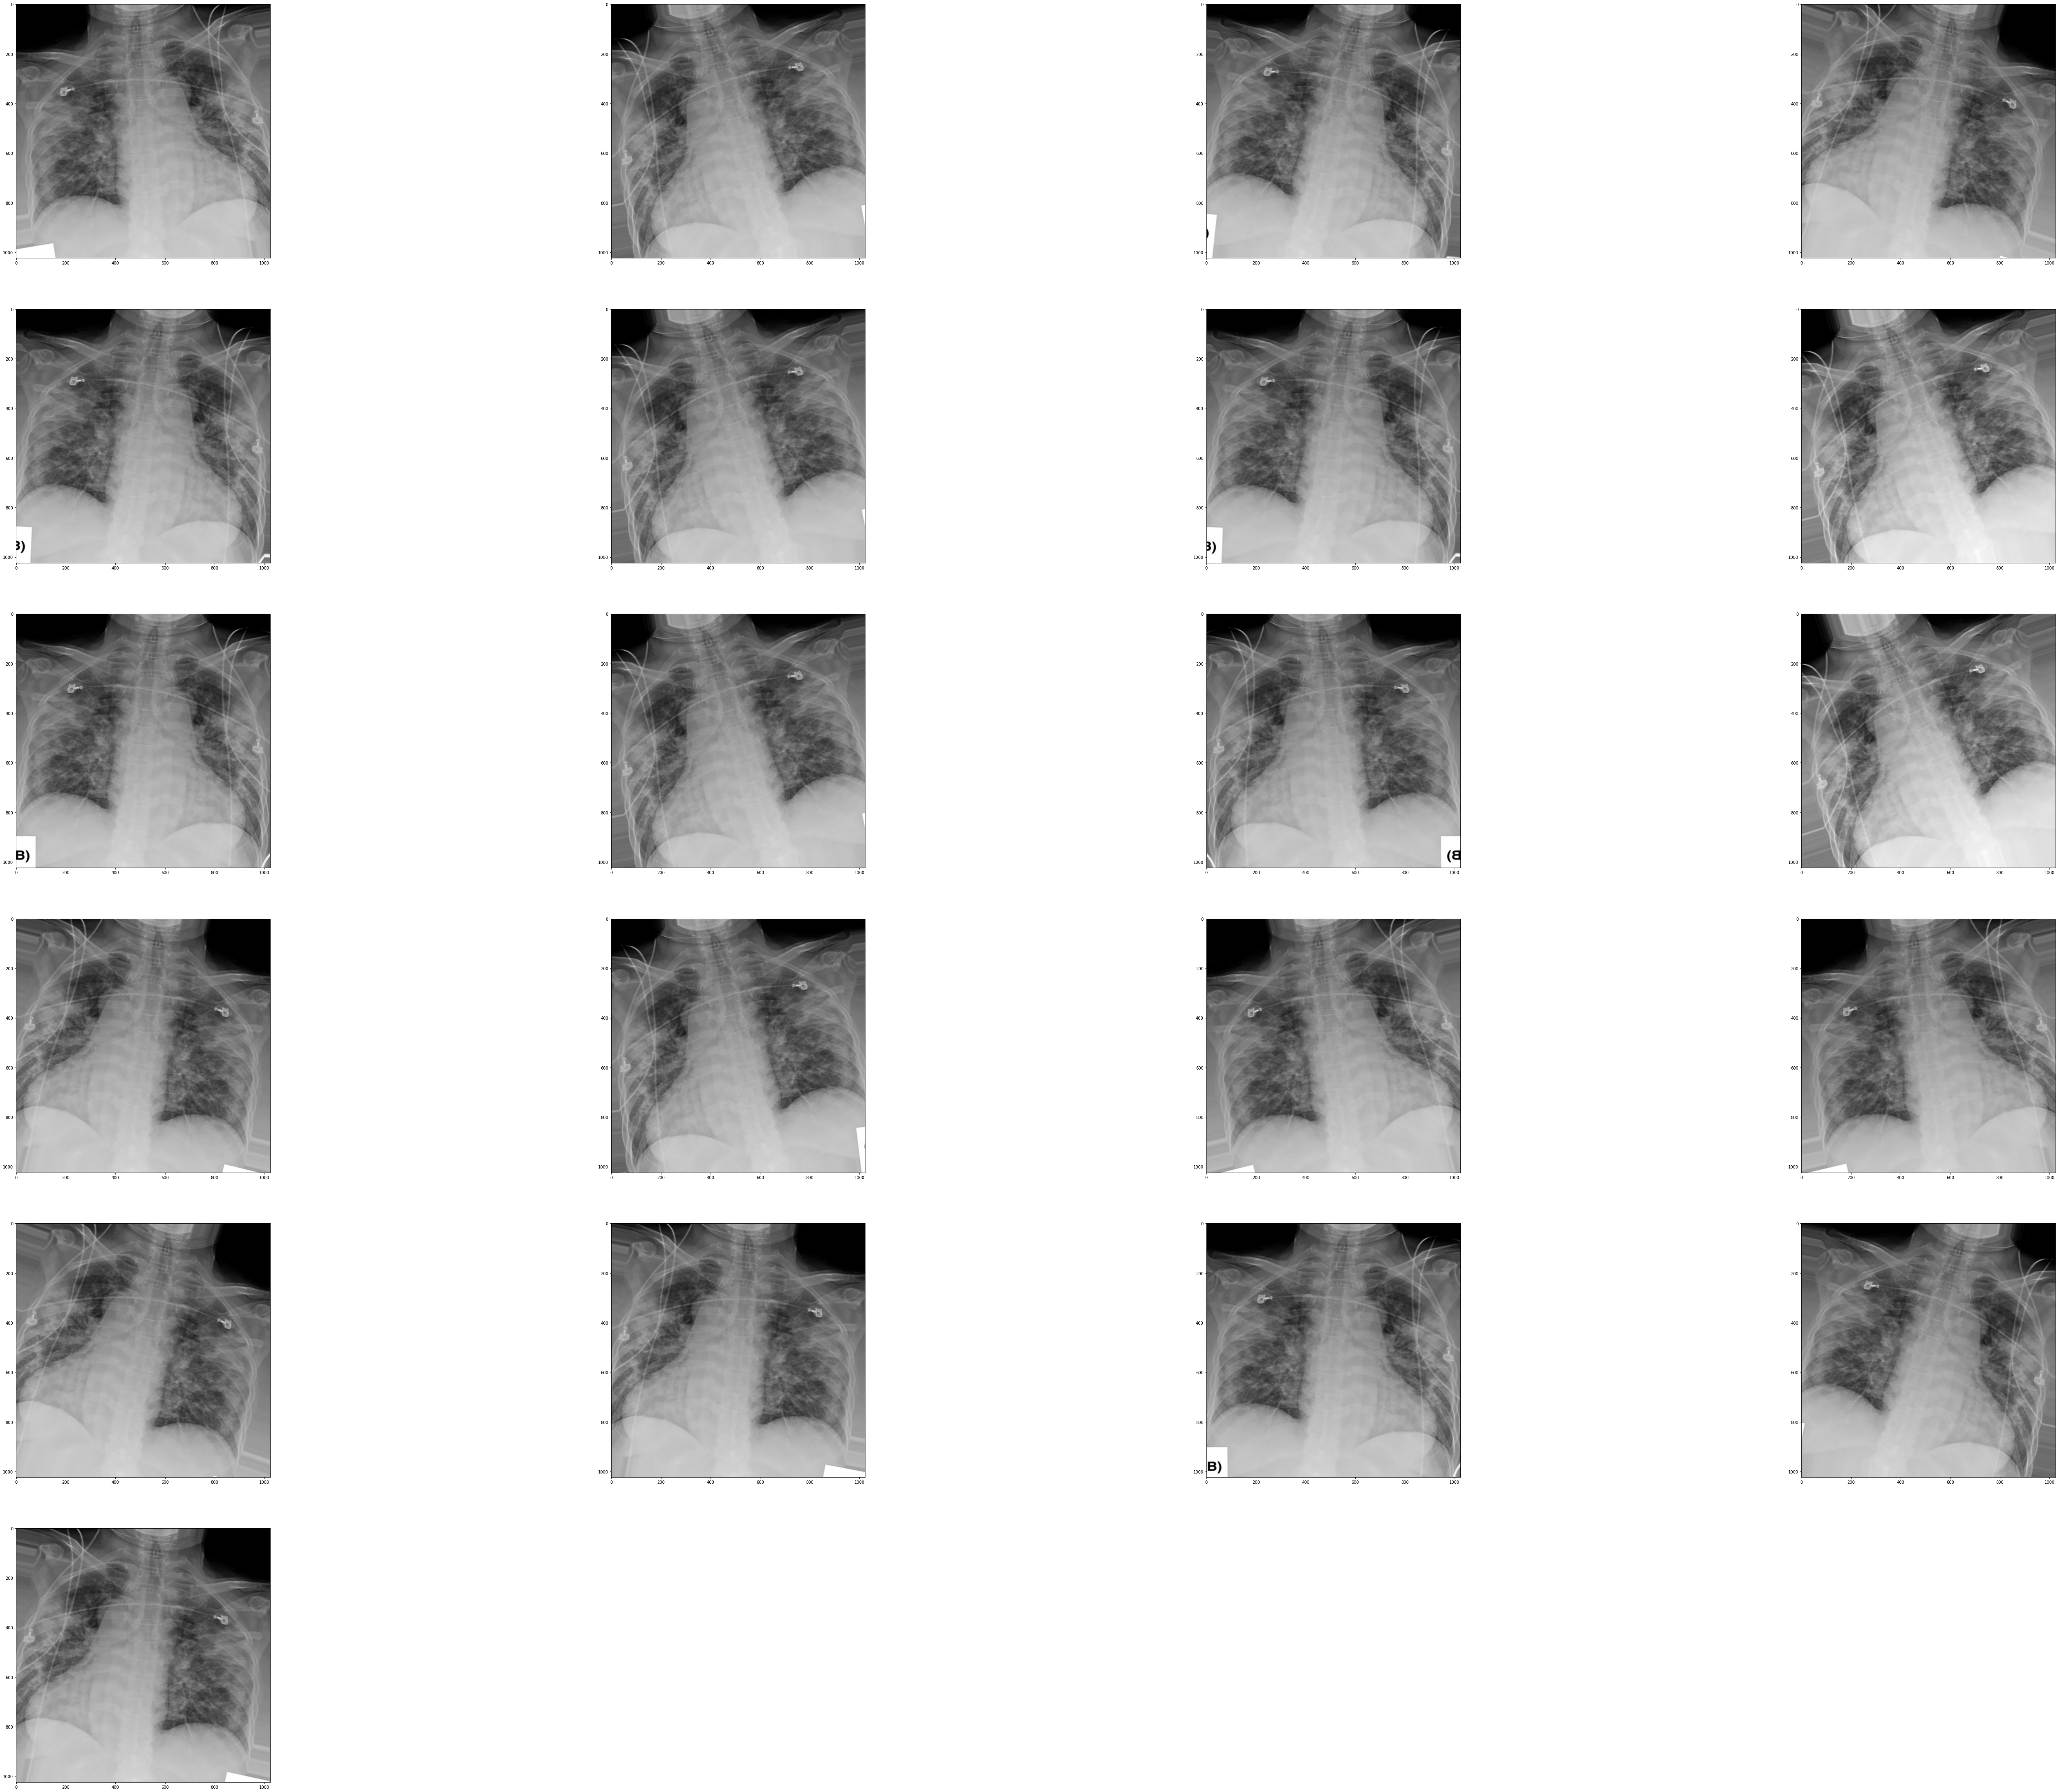

In [100]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('/home/jimi/dissertacao/covid19/dataset/dataset_final/test_augm/*.jpg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(100,80))
columns = 4
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [109]:
#verificando oresultado do data augmentation
data_dir = '/content/drive/My Drive/UNICAMP/databases/covid_aug2/'

nomal_len = len([iq for iq in os.scandir('/home/jimi/dissertacao/covid19/dataset/dataset_final/aug/normal')])
pneumonia_len  = len([iq for iq in os.scandir('/home/jimi/dissertacao/covid19/dataset/dataset_final/aug/pneumonia')])
covid_len  = len([iq for iq in os.scandir('/home/jimi/dissertacao/covid19/dataset/dataset_final/aug/covid')])

print("Normal: ", nomal_len)
print("pneumonia_len: ", pneumonia_len)
print("covid_len: ", covid_len)


Normal:  9986
pneumonia_len:  9990
covid_len:  10000


#Data augmentation and DataGen

In [134]:
# Load Kaggle Pneumonia Dataset
def get_dataset(path, label):

    return [[path+x, label] for x in os.listdir(path) if not x.startswith('.')]

In [136]:
# Load Kaggle Pneumonia Dataset
def get_dataset(path, label):
  return [[path+x, label] for x in os.listdir(path) if not x.startswith('.')]

#def split_dataset():
#path_drive = '/content/drive/My Drive/UNICAMP/databases/covid19/'
data_dir = '/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/'
root = data_dir
normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'

normal_xray = get_dataset(normal_dir, 'normal')
pneumonia_xray = get_dataset(pneumonia_dir, 'pneumonia')

#print(len(normal_xray), normal_xray[0:5])
#print(len(pneumonia_xray), pneumonia_xray[0:5])

# Load Covid-19 Dataset
# metadata_path='/content/drive/My Drive/UNICAMP/databases/covid19_v2/covid-chestxray-dataset/metadata.csv'
# srcpath = '/content/drive/My Drive/UNICAMP/databases/covid19_v2/covid-chestxray-dataset/images/'
# df=pd.read_csv(metadata_path)
# covid_patients=df['finding']=='COVID-19'
# PA=df['view']=='PA'
# PA_covid=df[covid_patients & PA]
covid_xray = get_dataset(covid_dir, 'covid')
#print(len(covid_xray), covid_xray[0:5])

# random.shuffle(normal_xray)
# #random.shuffle(pneumonia_xray)
# random.shuffle(covid_xray)

# gerando dados balanceados e randomizados
print("min_size = {}".format(min(len(normal_xray), len(pneumonia_xray), len(covid_xray))-1))
min_size = min(len(normal_xray), len(pneumonia_xray), len(covid_xray)) -1
dataset = normal_xray + pneumonia_xray + covid_xray
random.shuffle(dataset)

#print(len(dataset), dataset[0:5])

# carregando os dados para um df pandas
df = pd.DataFrame(dataset, columns=['X', 'y']).sample(frac=1)
#print(df)

X = df['X']
y = df['y']

print (X)
X.shape
print('----------')
print (y)
y.shape

classes= y.unique()
print("Classes: {}".format(classes))

# Split em train, val, e test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #pega % do treino e separa para teste/
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #pega % do treino e separa para teste

print("-----"*10)
print("Total de imagens= {}, \nDados para: treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(X_train), len(X_val), len(X_test)))
print("-----"*10)
print("Total Y= {}, \nDados para: Treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(y_train), len(y_val), len(y_test)))

!rm -rf '/content/drive/My Drive/UNICAMP/databases/covid19/train' #remove a pasta se ela ja existir
!rm -rf '/content/drive/My Drive/UNICAMP/databases/covid19/test' #remove a pasta se ela ja existir
!rm -rf '/content/drive/My Drive/UNICAMP/databases/covid19/val' #remove a pasta se ela ja existir

#cria uma nova pasta com as duas bases de dados agrupadas
for dtype, dinputs, doutputs in [['train', X_train, y_train], ['val', X_val, y_val], ['test', X_test, y_test]]:
  for _X, _y in zip(dinputs, doutputs):
    path = root+dtype+'/'+_y
    os.makedirs(path, exist_ok=True)
    print(_X, path)
    shutil.copy(_X, path)

  #!tar -czf dataset.tar.gz dataset/ #guarda toda a base obtida em um arquivo zip


min_size = 218
2364    /home/jimi/dissertacao/covid19/dataset/dataset...
869     /home/jimi/dissertacao/covid19/dataset/dataset...
885     /home/jimi/dissertacao/covid19/dataset/dataset...
2360    /home/jimi/dissertacao/covid19/dataset/dataset...
667     /home/jimi/dissertacao/covid19/dataset/dataset...
                              ...                        
538     /home/jimi/dissertacao/covid19/dataset/dataset...
636     /home/jimi/dissertacao/covid19/dataset/dataset...
2293    /home/jimi/dissertacao/covid19/dataset/dataset...
2011    /home/jimi/dissertacao/covid19/dataset/dataset...
970     /home/jimi/dissertacao/covid19/dataset/dataset...
Name: X, Length: 2905, dtype: object
----------
2364       normal
869     pneumonia
885        normal
2360       normal
667        normal
          ...    
538     pneumonia
636         covid
2293       normal
2011       normal
970     pneumonia
Name: y, Length: 2905, dtype: object
Classes: ['normal' 'pneumonia' 'covid']
------------------------

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (494).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (352).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (292).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (845).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (448).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1122).png /home/jimi/

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (699).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (823).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (650).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (968).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19(197).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (228).png /home/jimi/dissertacao/covid19/dataset/d

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1004).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (320).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (170).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (725).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (716).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1084)

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (774).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (254).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (819).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (980).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19(180).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (262).png /home/jimi/dissertacao/co

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (460).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (318).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (269).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1151).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (964).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (106).png /home/jimi/dissertacao/covid19/dataset

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19 (84).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (566).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (788).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1301).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (898).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1249).png /home/jimi/

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (973).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1037).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19(135).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (541).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (635).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1234).png /home/ji

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (777).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1010).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1061).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (861).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (216).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19(164).png /home/jimi/dissertacao

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (806).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (741).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (90).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (493).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19(162).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (601).png /home/jimi/dissertacao/covid1

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19(165).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (174).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1123).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19 (52).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1050).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (4).png /home/jimi/dissertacao/cov

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1298).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (887).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (171).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1129).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1150).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (455).png /home/jim

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1341).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (980).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1041).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1169).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (865).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (222).png /home/jimi/dissertacao/covid19/datas

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (438).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1246).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (545).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (241).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1210).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral 

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (344).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (235).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (748).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (676).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19 (125).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (82).pn

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (702).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (779).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (674).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1204).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1321).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19 (91).png /home/jimi/dissertacao/covid19/datase

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (395).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (578).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1255).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (914).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19 (8).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1187).p

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1329).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (878).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (818).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (841).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (37).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (761).png /home/jimi/dissertacao/c

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (538).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (52).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1237).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (652).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1185).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (903).png /home/jimi/

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1207).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (863).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (380).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (892).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19 (30).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (900).png /home/jimi/dissertacao/c

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19 (45).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (515).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1031).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (533).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1251).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (924).png /home/jimi/dissertacao/

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1015).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1227).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (510).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (508).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (371).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (376).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1271).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (6).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1145).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (150).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (548).png /home/jimi/dissertacao/covid19/dataset/

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (908).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (841).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (849).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (310).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (564).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1100).

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (895).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (791).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1120).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (253).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (389).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (377).png /home/ji

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (308).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (952).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (741).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1265).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (498).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (489).

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (12).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (3).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1288).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1177).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19(141).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (899).png /home/jimi/dissertacao/covid19/dataset/da

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (99).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (497).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1027).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1056).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (129).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1280).png /home/jimi/dissertacao/covid19/datase

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (210).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (205).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (620).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1263).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1066).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (853)

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (50).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1233).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1138).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1171).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (610).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (210).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19 (43).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (491).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1148).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (814).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (798).png /home/jimi/dissertacao/covid19/dataset/

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (304).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1324).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1033).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (754).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (404).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1190).png /home/jimi/dissertaca

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (584).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (388).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (682).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1242).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (707).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (14

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (40).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (528).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (413).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (804).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1165).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (548).png /home/jimi/d

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (294).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (393).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (497).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (690).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (594).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/train/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (955).png /home/jimi/dissertacao/c

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1306).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1071).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (338).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1312).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (80).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (441).png /home

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1321).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1025).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (236).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1151).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (886).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1001).png /home/jimi/dissert

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (207).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1207).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (431).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (576).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19(207).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (464).png /home/jimi/dissertacao/covid19/dat

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1307).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1164).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (582).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (986).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (859).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (537).png /home

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19(212).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (987).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (123).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (706).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1093).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (128).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggl

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (33).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (453).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (94).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (172).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1090).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (169).png /home/jimi/dissertacao/

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (146).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (976).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19 (57).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (161).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1173).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19 (131).png /home/jimi/dissertacao/covid19/da

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (953).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (319).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1032).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (259).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (351).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1168).png /home/jimi/dissertacao/covid19/dataset/dataset_

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (193).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (72).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (59).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1249).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (687).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/val/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (252).png /home/jimi/dissertacao/covid19/data

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1117).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (715).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (502).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1048).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (794).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19(182).png /home/jimi/d

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (740).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (694).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1091).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1262).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1247).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (668).png /home/jimi/

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (877).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (220).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1234).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1317).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (826).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (126).png /home/jimi/d

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (820).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (698).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (112).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (953).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (87).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (420).png /home/jimi/dissert

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (962).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19 (95).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (231).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1106).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (738).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (154).png /home/jimi/disser

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (214).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (60).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (140).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (520).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1217).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (363).png /h

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (951).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1012).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (515).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (75).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1281).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (748).png /home/jimi/dissertacao/covid19/dataset/data

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (889).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (78).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (718).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19 (108).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (722).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1075).png /home/jimi/disser

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19 (77).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (762).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19(149).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19 (107).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/covid/COVID-19(189).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/covid
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (493).png /home/jimi/dissertacao/covid19/dataset/dataset_kag

/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (1039).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (662).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/pneumonia/Viral Pneumonia (816).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/pneumonia
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (1293).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (766).png /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/test/normal
/home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/normal/NORMAL (385).png /home/jimi/dissertacao/covi

In [137]:
len_normal_train = len([iq for iq in os.scandir(data_dir+'train/normal')])
len_normal_val = len([iq for iq in os.scandir(data_dir+'val/normal')])
len_normal_test = len([iq for iq in os.scandir(data_dir+'test/normal')])

len_pneumonia_train = len([iq for iq in os.scandir(data_dir+'train/pneumonia')])
len_pneumonia_val = len([iq for iq in os.scandir(data_dir+'val/pneumonia')])
len_pneumonia_test = len([iq for iq in os.scandir(data_dir+'test/pneumonia')])

len_test_train = len([iq for iq in os.scandir(data_dir+'train/covid')])
len_test_val = len([iq for iq in os.scandir(data_dir+'val/covid')])
len_test_test = len([iq for iq in os.scandir(data_dir+'test/covid')])

#totais
len_train_total = len_normal_train + len_pneumonia_train + len_test_train
len_val_total = len_pneumonia_val + len_test_val + len_normal_val
len_test_total = len_normal_test + len_pneumonia_test + len_test_test

print("Totais parciais")
print("---------------------")
print ("normal no train: ", len_normal_train)
print ("normal no val: ", len_normal_val)
print ("normal no test: ", len_normal_test)
print("---------------------")
print ("pneumonia no train: ", len_pneumonia_train)
print ("pneumonia no val: ", len_pneumonia_val)
print ("pneumonia no test: ", len_pneumonia_test)
print("---------------------")
print ("covid no train: ", len_test_train)
print ("covid no val: ", len_test_val)
print ("covid no test: ", len_test_test)
print()
print("Totais")
print("---------------------")
print("total train: ", len_train_total)
print("total val: ", len_val_total)
print("total test: ", len_test_total)


Totais parciais
---------------------
normal no train:  877
normal no val:  213
normal no test:  251
---------------------
pneumonia no train:  850
pneumonia no val:  217
pneumonia no test:  278
---------------------
covid no train:  132
covid no val:  35
covid no test:  52

Totais
---------------------
total train:  1859
total val:  465
total test:  581


In [138]:
image_size = 224

data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator_no_aug.flow_from_directory(
       directory = train_dir,
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
       directory = val_dir,
       target_size = (image_size, image_size),
       class_mode = 'categorical')

test_generator= data_generator_no_aug.flow_from_directory(
       directory = test_dir,
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')

Found 13033 images belonging to 3 classes.
Found 3260 images belonging to 3 classes.
Found 4075 images belonging to 3 classes.


#Visualizando algumas amostras dos datasets

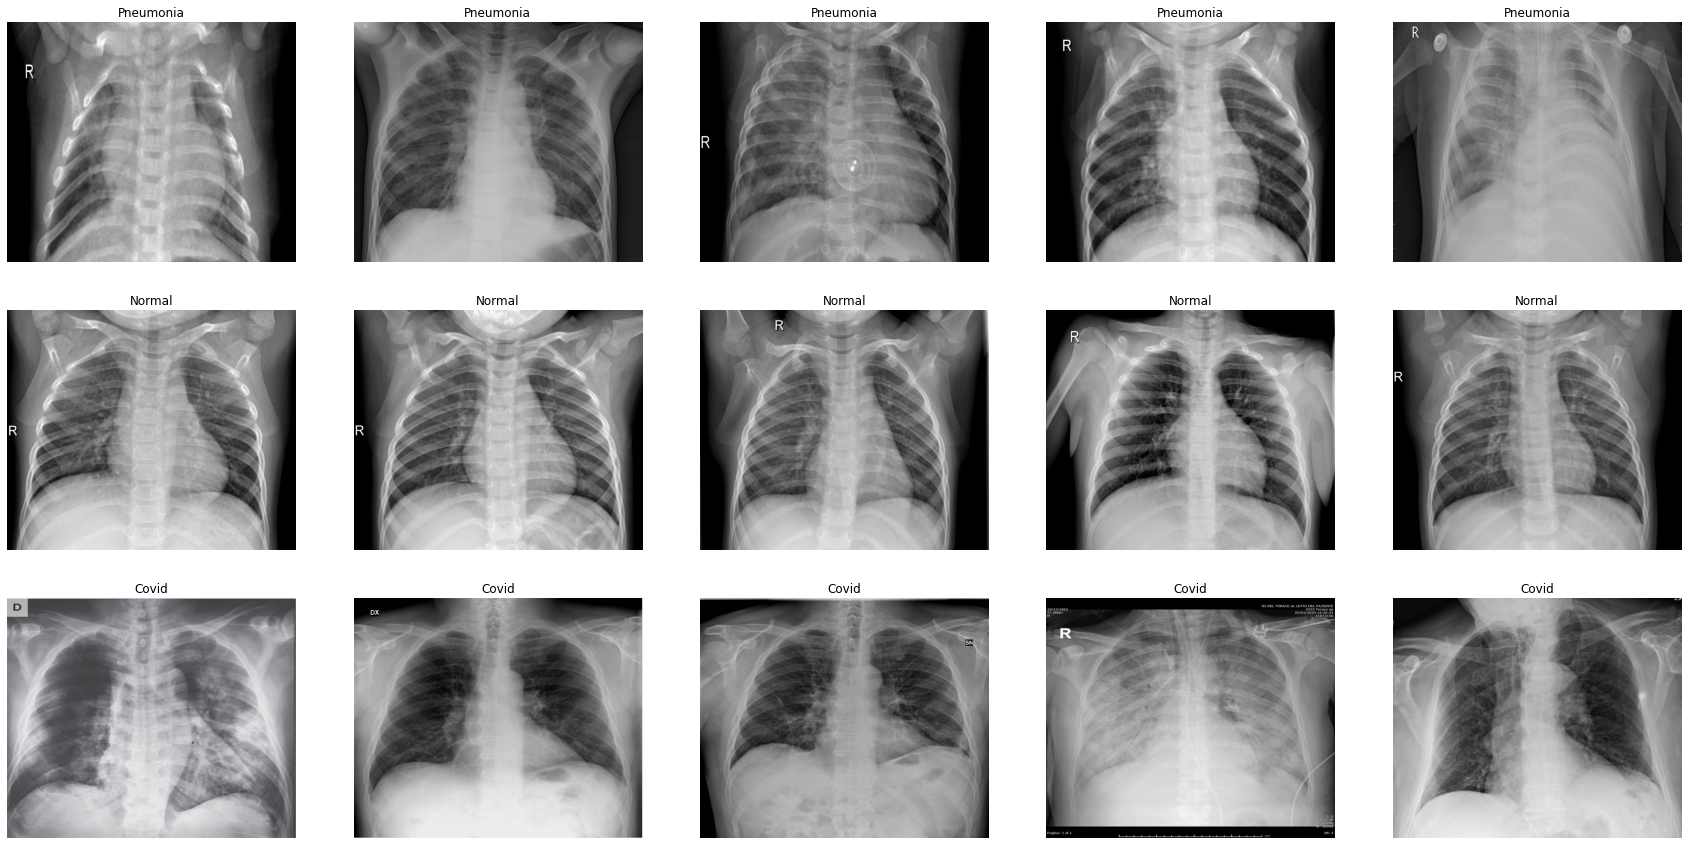

In [0]:
### VERIFICAR SE AS CLASSES ESTÃO CORRETAS

# Get the list of all the images
normal_cases = glob(normal_cases_dir+'/*.jpeg')
pneumonia_cases = glob(pneumonia_cases_dir+'/*.jpeg')
covid_cases = glob(covid_cases_dir+'/*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Go through all the covid cases. The label for these cases will be 2
for img in covid_cases:
    train_data.append((img, 2))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()
covid_samples = (train_data[train_data['label']==2]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples + covid_samples
del pneumonia_samples, normal_samples, covid_samples

# Plot the data 
f, ax = plt.subplots(3,5, figsize=(30,15))
for i in range(15):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    elif i>=5 and i<10:
        ax[i//5, i%5].set_title("Normal")
    else:
        ax[i//5, i%5].set_title("Covid")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

#Modelos

##Nosso botton model

In [139]:
def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(64, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(64, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

##DenseNet201

/home/jimi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/100
116/116 [==============================] - 81s 698ms/step - loss: 0.4072 - accuracy: 0.8173 - val_loss: 1.5600 - val_accuracy: 0.6717

Epoch 00001: val_loss improved from inf to 1.56001, saving model to /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/DenseNet201-v9-.h5
Epoch 2/100
116/116 [==============================] - 81s 697ms/step - loss: 0.2350 - accuracy: 0.9240 - val_loss: 1.9274 - val_accuracy: 0.6264

Epoch 00002: val_loss did not improve from 1.56001
Epoch 3/100
116/116 [==============================] - 83s 718ms/step - loss: 0.2197 - accuracy: 0.9265 - val_loss: 1.5348 - val_accuracy: 0.5941

Epoch 00003: val_loss improved from 1.56001 to 1.53476, saving model to /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/DenseNet201-v9-.h5
Epoch 4/100
116/116 [==============================] - 71s 610ms/step - loss: 0.1936 - accuracy: 0.9355 - val_loss: 0.9042 - val_accuracy: 0.6548

Epoch 00004: val_loss improved from 1.53476 to 0.

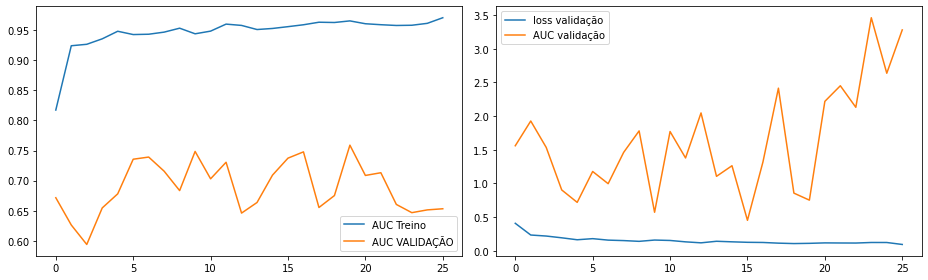

In [142]:
#DenseNet201
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

DenseNet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet201.layers:
  layer.trainable=False

FC = addTopModel(DenseNet201, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet201.input, output=FC) #bottom layers, top layer


#model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet201'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##DenseNet121

##teste 1 - 1 dense de 1024

/home/jimi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/100
116/116 [==============================] - 62s 537ms/step - loss: 0.6245 - accuracy: 0.8400 - val_loss: 1.5994 - val_accuracy: 0.6595

Epoch 00001: val_loss improved from inf to 1.59935, saving model to /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/DenseNet121-v9-.h5
Epoch 2/100
116/116 [==============================] - 52s 447ms/step - loss: 0.2182 - accuracy: 0.9180 - val_loss: 1.4542 - val_accuracy: 0.6627

Epoch 00002: val_loss improved from 1.59935 to 1.45423, saving model to /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/DenseNet121-v9-.h5
Epoch 3/100
116/116 [==============================] - 52s 450ms/step - loss: 0.1872 - accuracy: 0.9313 - val_loss: 3.1721 - val_accuracy: 0.6376

Epoch 00003: val_loss did not improve from 1.45423
Epoch 4/100
116/116 [==============================] - 51s 443ms/step - loss: 0.1830 - accuracy: 0.9301 - val_loss: 3.5547 - val_accuracy: 0.6172

Epoch 00004: val_loss did not improve from 1.4542

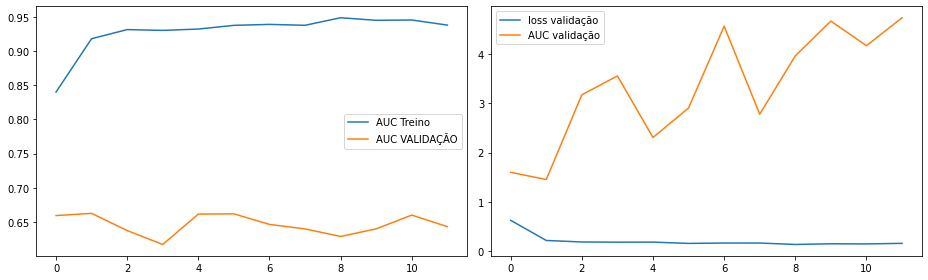

In [143]:
#DenseNet201
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##teste 2 - Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)

/home/jimi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/100
116/116 [==============================] - 62s 536ms/step - loss: 0.3565 - accuracy: 0.8502 - val_loss: 1.7106 - val_accuracy: 0.6699

Epoch 00001: val_loss improved from inf to 1.71060, saving model to /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/DenseNet121-v9-.h5
Epoch 2/100
116/116 [==============================] - 52s 447ms/step - loss: 0.2182 - accuracy: 0.9180 - val_loss: 1.6692 - val_accuracy: 0.6369

Epoch 00002: val_loss improved from 1.71060 to 1.66925, saving model to /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/DenseNet121-v9-.h5
Epoch 3/100
116/116 [==============================] - 53s 453ms/step - loss: 0.1988 - accuracy: 0.9262 - val_loss: 1.7105 - val_accuracy: 0.6437

Epoch 00003: val_loss did not improve from 1.66925
Epoch 4/100
116/116 [==============================] - 51s 441ms/step - loss: 0.1741 - accuracy: 0.9328 - val_loss: 1.8942 - val_accuracy: 0.6465

Epoch 00004: val_loss did not improve from 1.6692

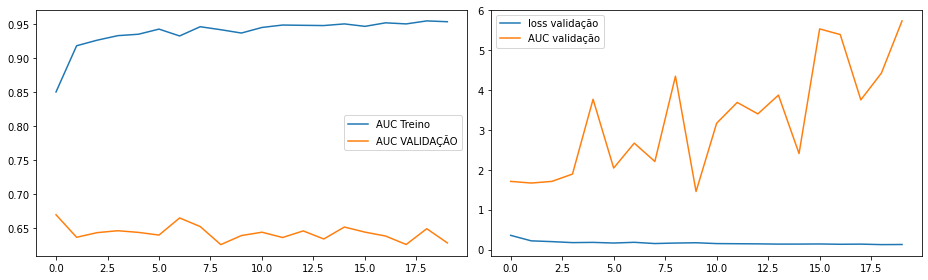

In [144]:
#DenseNet201
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

## teste 3 - 6 dense decrescentes

/home/jimi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/100
116/116 [==============================] - 64s 548ms/step - loss: 0.5573 - accuracy: 0.7160 - val_loss: 1.3921 - val_accuracy: 0.6462

Epoch 00001: val_accuracy improved from -inf to 0.64619, saving model to /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/DenseNet121-v9-.h5
Epoch 2/100
116/116 [==============================] - 60s 520ms/step - loss: 0.2775 - accuracy: 0.9058 - val_loss: 2.7317 - val_accuracy: 0.6505

Epoch 00002: val_accuracy improved from 0.64619 to 0.65050, saving model to /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/DenseNet121-v9-.h5
Epoch 3/100
116/116 [==============================] - 64s 552ms/step - loss: 0.2298 - accuracy: 0.9219 - val_loss: 2.8745 - val_accuracy: 0.6300

Epoch 00003: val_accuracy did not improve from 0.65050
Epoch 4/100
116/116 [==============================] - 65s 561ms/step - loss: 0.2161 - accuracy: 0.9321 - val_loss: 3.8658 - val_accuracy: 0.6266

Epoch 00004: val_accuracy did not im

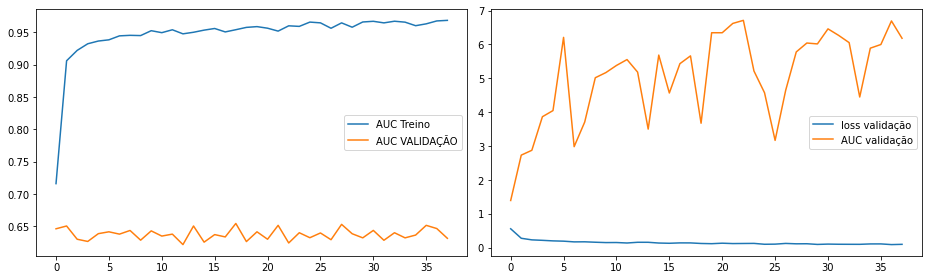

In [145]:
# MELHOR 109/109 [==============================] - 506s 5s/step - loss: 0.1973 - accuracy: 0.9293 - val_loss: 0.0946 - val_accuracy: 0.9259
#Epoch 00015: val_accuracy improved from 0.91647 to 0.92593, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/DenseNet121-v9-.h5

from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(64, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(64, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_accuracy',
                             mode="max",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=20,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=20,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

## Teste 3b - 3 dense - ADAM

/home/jimi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/100
116/116 [==============================] - 79s 684ms/step - loss: 0.3414 - accuracy: 0.8624 - val_loss: 0.9056 - val_accuracy: 0.7044

Epoch 00001: val_accuracy improved from -inf to 0.70438, saving model to /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/DenseNet121-v9-.h5
Epoch 2/100
116/116 [==============================] - 83s 712ms/step - loss: 0.1933 - accuracy: 0.9259 - val_loss: 2.9348 - val_accuracy: 0.6386

Epoch 00002: val_accuracy did not improve from 0.70438
Epoch 3/100
116/116 [==============================] - 103s 886ms/step - loss: 0.1761 - accuracy: 0.9332 - val_loss: 4.1504 - val_accuracy: 0.6527

Epoch 00003: val_accuracy did not improve from 0.70438
Epoch 4/100
116/116 [==============================] - 88s 762ms/step - loss: 0.1458 - accuracy: 0.9470 - val_loss: 3.0924 - val_accuracy: 0.6183

Epoch 00004: val_accuracy did not improve from 0.70438
Epoch 5/100
116/116 [==============================] - 64s 555ms/step - loss: 0.1546 - 

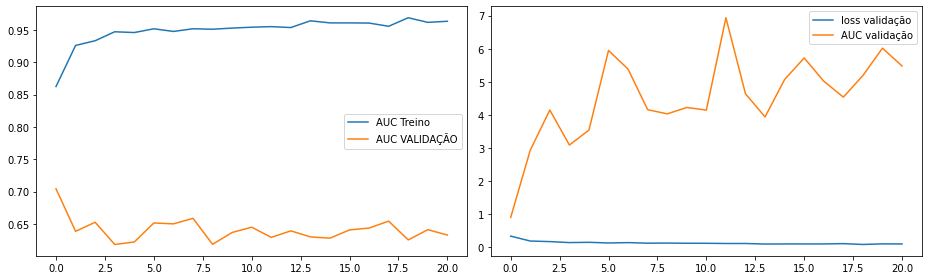

In [146]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_accuracy',
                             mode="max",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=20,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=20,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

## Teste 3c - 5 dense - com ADAM

/home/jimi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/100
116/116 [==============================] - 86s 741ms/step - loss: 0.5762 - accuracy: 0.6925 - val_loss: 0.7139 - val_accuracy: 0.6070

Epoch 00001: val_accuracy improved from -inf to 0.60704, saving model to /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/DenseNet121-v9-.h5
Epoch 2/100
116/116 [==============================] - 95s 820ms/step - loss: 0.4065 - accuracy: 0.8003 - val_loss: 1.0523 - val_accuracy: 0.6717

Epoch 00002: val_accuracy improved from 0.60704 to 0.67170, saving model to /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/DenseNet121-v9-.h5
Epoch 3/100
116/116 [==============================] - 111s 954ms/step - loss: 0.2902 - accuracy: 0.8839 - val_loss: 1.5220 - val_accuracy: 0.6591

Epoch 00003: val_accuracy did not improve from 0.67170
Epoch 4/100
116/116 [==============================] - 95s 822ms/step - loss: 0.2553 - accuracy: 0.9046 - val_loss: 2.1713 - val_accuracy: 0.6418

Epoch 00004: val_accuracy did not i

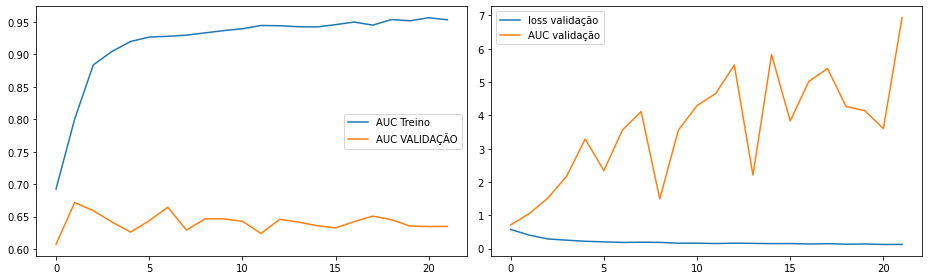

In [147]:
#melhores até agora neste modelo
#Epoch 98/100
#109/109 [==============================] - 59s 542ms/step - loss: 0.1392 - accuracy: 0.9486 - val_loss: 0.1121 - val_accuracy: 0.9196
#Epoch 99/100
#109/109 [==============================] - 59s 544ms/step - loss: 0.1247 - accuracy: 0.9547 - val_loss: 0.2072 - val_accuracy: 0.9377

from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(32, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_accuracy',
                             mode="max",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=20,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=20,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Teste 4 - 2 dense 1024, 512 COM SGD

/home/jimi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/100
116/116 [==============================] - 81s 697ms/step - loss: 0.5113 - accuracy: 0.7495 - val_loss: 1.5477 - val_accuracy: 0.6742

Epoch 00001: val_loss improved from inf to 1.54774, saving model to /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/DenseNet121-v9-.h5
Epoch 2/100
116/116 [==============================] - 86s 744ms/step - loss: 0.3466 - accuracy: 0.8522 - val_loss: 1.5871 - val_accuracy: 0.6724

Epoch 00002: val_loss did not improve from 1.54774
Epoch 3/100
116/116 [==============================] - 108s 930ms/step - loss: 0.2792 - accuracy: 0.8887 - val_loss: 1.5379 - val_accuracy: 0.6710

Epoch 00003: val_loss improved from 1.54774 to 1.53790, saving model to /home/jimi/dissertacao/covid19/dataset/dataset_kaggle/dataset_base/DenseNet121-v9-.h5
Epoch 4/100
116/116 [==============================] - 92s 793ms/step - loss: 0.2583 - accuracy: 0.8976 - val_loss: 1.2199 - val_accuracy: 0.6724

Epoch 00004: val_loss improved from 1.53790 to 1

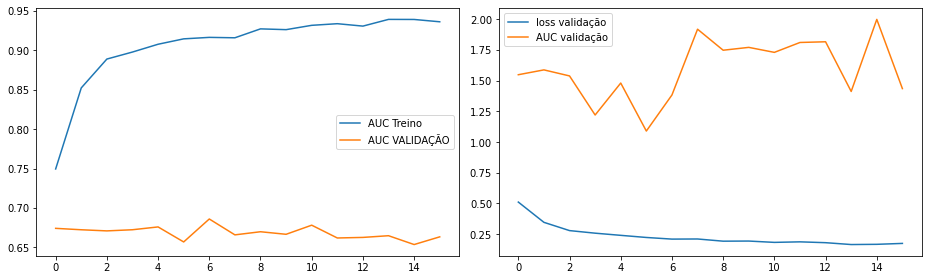

In [148]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Teste 5 - 6 dense decrescente - Com SGD

In [149]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_accuracy',
                             mode="max",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

/home/jimi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/100
115/116 [============================>.] - ETA: 0s - loss: 0.4859 - accuracy: 0.7624

KeyboardInterrupt: 

##Teste 5b - 3 dense - SDG

In [ ]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_accuracy',
                             mode="max",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Teste 5b - 5 dense - SGD

In [ ]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(32, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_accuracy',
                             mode="max",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Teste 6 - 1 dense 256

/home/jimi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/100
407/407 [==============================] - 202s 496ms/step - loss: 0.4213 - accuracy: 0.8045 - val_loss: 1.1172 - val_accuracy: 0.7161

Epoch 00001: val_accuracy improved from -inf to 0.71607, saving model to /home/jimi/dissertacao/covid19/dataset/dataset_final/DenseNet121-v9-.h5
Epoch 2/100
407/407 [==============================] - 201s 493ms/step - loss: 0.2801 - accuracy: 0.8873 - val_loss: 0.9812 - val_accuracy: 0.6734

Epoch 00002: val_accuracy did not improve from 0.71607
Epoch 3/100
407/407 [==============================] - 201s 494ms/step - loss: 0.2446 - accuracy: 0.9045 - val_loss: 1.0677 - val_accuracy: 0.6835

Epoch 00003: val_accuracy did not improve from 0.71607
Epoch 4/100
407/407 [==============================] - 200s 492ms/step - loss: 0.2227 - accuracy: 0.9145 - val_loss: 1.5151 - val_accuracy: 0.6677

Epoch 00004: val_accuracy did not improve from 0.71607
Epoch 5/100
407/407 [==============================] - 201s 493ms/step - loss: 0.2084 - accuracy: 

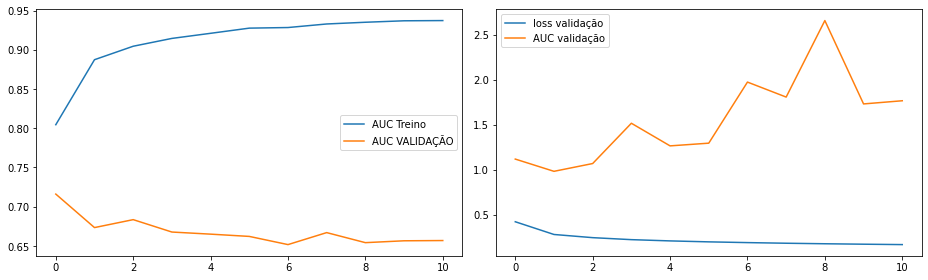

In [130]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_accuracy',
                             mode="max",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##ResNet50v2

234553344/234545216 [==============================] - 11s 0us/step


/home/jimi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


Epoch 1/100
407/407 [==============================] - 207s 508ms/step - loss: 0.2129 - accuracy: 0.9191 - val_loss: 5.0094 - val_accuracy: 0.6287

Epoch 00001: val_loss improved from inf to 5.00945, saving model to /home/jimi/dissertacao/covid19/dataset/dataset_final/ResNet152V2-v9-.h5
Epoch 2/100
407/407 [==============================] - 203s 498ms/step - loss: 0.1581 - accuracy: 0.9415 - val_loss: 5.3434 - val_accuracy: 0.6285

Epoch 00002: val_loss did not improve from 5.00945
Epoch 3/100
407/407 [==============================] - 204s 501ms/step - loss: 0.1414 - accuracy: 0.9481 - val_loss: 5.7984 - val_accuracy: 0.6510

Epoch 00003: val_loss did not improve from 5.00945
Epoch 4/100
407/407 [==============================] - 204s 500ms/step - loss: 0.1278 - accuracy: 0.9532 - val_loss: 5.1230 - val_accuracy: 0.6640

Epoch 00004: val_loss did not improve from 5.00945
Epoch 5/100
407/407 [==============================] - 203s 498ms/step - loss: 0.1184 - accuracy: 0.9570 - val_loss

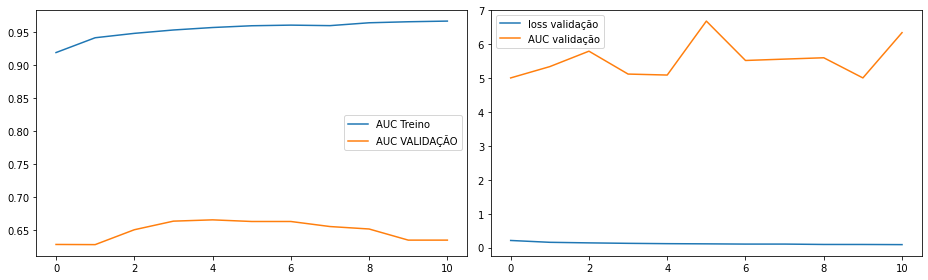

In [131]:
#ResNet152V2
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

ResNet152V2 = ResNet152V2(include_top=False, weights='imagenet', input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido, 1pb

for layer in ResNet152V2.layers:
  layer.trainable=False

FC = addTopModel(ResNet152V2, num_classes) #MobileNet = bottom_model
model = Model(input=ResNet152V2.input, output=FC) #bottom layers, top layer

#model.summary()

name_model = 'ResNet152V2'+version+'.h5'

checkpoint = ModelCheckpoint(data_dir+'ResNet152V2'+version+'.h5',
                            monitor='val_loss',
                            mode="min",
                            save_best_only=True,
                            verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# # Evaluate the model
# scores = history.history.evaluate_generator(test_generator)
# print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

#confuzin and matrix
#print(classification_report())

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##InceptionResNetv2

In [132]:
#InceptionResNetV2
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

InceptionResNetV2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in InceptionResNetV2.layers:
  layer.trainable=False

FC = addTopModel(InceptionResNetV2, num_classes) #MobileNet = bottom_model
model = Model(input=InceptionResNetV2.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'InceptionResNetV2'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

219062272/219055592 [==============================] - 10s 0us/step


/home/jimi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/100
407/407 [==============================] - 207s 509ms/step - loss: 0.3317 - accuracy: 0.8592 - val_loss: 6.3453 - val_accuracy: 0.6293

Epoch 00001: val_loss improved from inf to 6.34530, saving model to /home/jimi/dissertacao/covid19/dataset/dataset_final/InceptionResNetV2-v9-.h5
Epoch 2/100
407/407 [==============================] - 204s 501ms/step - loss: 0.2623 - accuracy: 0.8975 - val_loss: 5.6774 - val_accuracy: 0.6287

Epoch 00002: val_loss improved from 6.34530 to 5.67738, saving model to /home/jimi/dissertacao/covid19/dataset/dataset_final/InceptionResNetV2-v9-.h5
Epoch 3/100
407/407 [==============================] - 203s 499ms/step - loss: 0.2395 - accuracy: 0.9074 - val_loss: 6.0113 - val_accuracy: 0.6281

Epoch 00003: val_loss did not improve from 5.67738
Epoch 4/100
 53/407 [==>...........................] - ETA: 2:18 - loss: 0.2368 - accuracy: 0.9076

KeyboardInterrupt: 

##Inceptionv3

In [ ]:
#Inception2
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

InceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in InceptionV3.layers:
  layer.trainable=False

FC = addTopModel(InceptionV3, num_classes) #MobileNet = bottom_model
model = Model(input=InceptionV3.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'InceptionV3'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##VGG19

In [ ]:
#VGG19
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

VGG19 = VGG19(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in VGG19.layers:
  layer.trainable=False

FC = addTopModel(VGG19, num_classes) #MobileNet = bottom_model
model = Model(input=VGG19.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'VGG19'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# # Evaluate the model
# scores = history.history.evaluate_generator(test_generator)
# print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##MobileNet

In [ ]:
#MobileNetV2
MobileNetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in MobileNetV2.layers:
  layer.trainable=False

FC = addTopModel(MobileNetV2, num_classes) #MobileNet = bottom_model
model = Model(input=MobileNetV2.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'MobileNetV2'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# # Evaluate the model
# scores = history.history.evaluate_generator(test_generator)
# print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

In [27]:
#NASNetLarge
NASNetLarge = NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in NASNetLarge.layers:
  layer.trainable=False

FC = addTopModel(NASNetLarge, num_classes) #MobileNet = bottom_model
model = Model(input=NASNetLarge.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint('NASNetLarge'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

ValueError: When setting `include_top=True` and loading `imagenet` weights, `input_shape` should be (331, 331, 3).

##Xcepiton

##CheXNet

###Download do modelo

In [0]:
%%shell

cd '/content/drive/My Drive/UNICAMP/databases/chexnet'
git clone https://github.com/jrzech/reproduce-chexnet.git

Cloning into 'reproduce-chexnet'...
remote: Enumerating objects: 668, done.
remote: Total 668 (delta 0), reused 0 (delta 0), pack-reused 668
Receiving objects: 100% (668/668), 272.61 MiB | 18.50 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Checking out files: 100% (638/638), done.


###Model

In [0]:
#import
import torch
import pandas as pd
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import sklearn
import sklearn.metrics as sklm
from torch.autograd import Variable
import numpy as np
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
import os
from PIL import Image
from skimage import io, transform
import time
from shutil import copyfile
from shutil import rmtree
import csv
from copy import deepcopy
import scipy as sp
from pylab import *
import seaborn as sns
from matplotlib.pyplot import show

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

use_gpu = torch.cuda.is_available()
gpu_count = torch.cuda.device_count()
print("Available GPU count:" + str(gpu_count))

#DEFS
class CXRDataset(Dataset):

    def __init__(
            self,
            path_to_images,
            fold,
            transform=None,
            sample=0,
            finding="any",
            starter_images=False):

        self.transform = transform
        self.path_to_images = path_to_images
        self.df = pd.read_csv("/content/drive/My Drive/UNICAMP/databases/chexnet/reproduce-chexnet/nih_labels.csv")
        self.df = self.df[self.df['fold'] == fold]

        if(starter_images):
            starter_images = pd.read_csv("starter_images.csv")
            self.df=pd.merge(left=self.df,right=starter_images, how="inner",on="Image Index")

        # can limit to sample, useful for testing
        # if fold == "train" or fold =="val": sample=500
        if(sample > 0 and sample < len(self.df)):
            self.df = self.df.sample(sample)

        if not finding == "any":  # can filter for positive findings of the kind described; useful for evaluation
            if finding in self.df.columns:
                if len(self.df[self.df[finding] == 1]) > 0:
                    self.df = self.df[self.df[finding] == 1]
                else:
                    print("No positive cases exist for "+LABEL+", returning all unfiltered cases")
            else:
                print("cannot filter on finding " + finding +
                      " as not in data - please check spelling")

        self.df = self.df.set_index("Image Index")
        self.PRED_LABEL = [
            'Atelectasis',
            'Cardiomegaly',
            'Effusion',
            'Infiltration',
            'Mass',
            'Nodule',
            'Pneumonia',
            'Pneumothorax',
            'Consolidation',
            'Edema',
            'Emphysema',
            'Fibrosis',
            'Pleural_Thickening',
            'Hernia']
        RESULT_PATH = "results/"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        image = Image.open(
            os.path.join(
                self.path_to_images,
                self.df.index[idx]))
        image = image.convert('RGB')

        label = np.zeros(len(self.PRED_LABEL), dtype=int)
        for i in range(0, len(self.PRED_LABEL)):
             # can leave zero if zero, else make one
            if(self.df[self.PRED_LABEL[i].strip()].iloc[idx].astype('int') > 0):
                label[i] = self.df[self.PRED_LABEL[i].strip()
                                   ].iloc[idx].astype('int')

        if self.transform:
            image = self.transform(image)

        return (image, label,self.df.index[idx])

def make_pred_multilabel(data_transforms, model, PATH_TO_IMAGES):
    """
    Gives predictions for test fold and calculates AUCs using previously trained model

    Args:
        data_transforms: torchvision transforms to preprocess raw images; same as validation transforms
        model: densenet-121 from torchvision previously fine tuned to training data
        PATH_TO_IMAGES: path at which NIH images can be found
    Returns:
        pred_df: dataframe containing individual predictions and ground truth for each test image
        auc_df: dataframe containing aggregate AUCs by train/test tuples
    """

    # calc preds in batches of 16, can reduce if your GPU has less RAM
    BATCH_SIZE = 16

    # set model to eval mode; required for proper predictions given use of batchnorm
    model.train(False)

    # create dataloader
    dataset = CXRDataset(
        path_to_images=PATH_TO_IMAGES,
        fold="test",
        transform=data_transforms['val'])
    dataloader = torch.utils.data.DataLoader(
        dataset, BATCH_SIZE, shuffle=False, num_workers=8)
    size = len(dataset)

    # create empty dfs
    pred_df = pd.DataFrame(columns=["Image Index"])
    true_df = pd.DataFrame(columns=["Image Index"])

    # iterate over dataloader
    for i, data in enumerate(dataloader):

        inputs, labels, _ = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        true_labels = labels.cpu().data.numpy()
        batch_size = true_labels.shape

        outputs = model(inputs)
        probs = outputs.cpu().data.numpy()

        # get predictions and true values for each item in batch
        for j in range(0, batch_size[0]):
            thisrow = {}
            truerow = {}
            thisrow["Image Index"] = dataset.df.index[BATCH_SIZE * i + j]
            truerow["Image Index"] = dataset.df.index[BATCH_SIZE * i + j]

            # iterate over each entry in prediction vector; each corresponds to
            # individual label
            for k in range(len(dataset.PRED_LABEL)):
                thisrow["prob_" + dataset.PRED_LABEL[k]] = probs[j, k]
                truerow[dataset.PRED_LABEL[k]] = true_labels[j, k]

            pred_df = pred_df.append(thisrow, ignore_index=True)
            true_df = true_df.append(truerow, ignore_index=True)

        if(i % 10 == 0):
            print(str(i * BATCH_SIZE))

    auc_df = pd.DataFrame(columns=["label", "auc"])

    # calc AUCs
    for column in true_df:

        if column not in [
            'Atelectasis',
            'Cardiomegaly',
            'Effusion',
            'Infiltration',
            'Mass',
            'Nodule',
            'Pneumonia',
            'Pneumothorax',
            'Consolidation',
            'Edema',
            'Emphysema',
            'Fibrosis',
            'Pleural_Thickening',
                'Hernia']:
                    continue
        actual = true_df[column]
        pred = pred_df["prob_" + column]
        thisrow = {}
        thisrow['label'] = column
        thisrow['auc'] = np.nan
        try:
            thisrow['auc'] = sklm.roc_auc_score(
                actual.as_matrix().astype(int), pred.as_matrix())
        except BaseException:
            print("can't calculate auc for " + str(column))
        auc_df = auc_df.append(thisrow, ignore_index=True)

    pred_df.to_csv("results/preds.csv", index=False)
    auc_df.to_csv("results/aucs.csv", index=False)
    return pred_df, auc_df

def checkpoint(model, best_loss, epoch, LR):
    """
    Saves checkpoint of torchvision model during training.

    Args:
        model: torchvision model to be saved
        best_loss: best val loss achieved so far in training
        epoch: current epoch of training
        LR: current learning rate in training
    Returns:
        None
    """

    print('saving')
    state = {
        'model': model,
        'best_loss': best_loss,
        'epoch': epoch,
        'rng_state': torch.get_rng_state(),
        'LR': LR
    }

    torch.save(state, 'results/checkpoint')


def train_model(
        model,
        criterion,
        optimizer,
        LR,
        num_epochs,
        dataloaders,
        dataset_sizes,
        weight_decay):
    """
    Fine tunes torchvision model to NIH CXR data.

    Args:
        model: torchvision model to be finetuned (densenet-121 in this case)
        criterion: loss criterion (binary cross entropy loss, BCELoss)
        optimizer: optimizer to use in training (SGD)
        LR: learning rate
        num_epochs: continue training up to this many epochs
        dataloaders: pytorch train and val dataloaders
        dataset_sizes: length of train and val datasets
        weight_decay: weight decay parameter we use in SGD with momentum
    Returns:
        model: trained torchvision model
        best_epoch: epoch on which best model val loss was obtained

    """
    since = time.time()

    start_epoch = 1
    best_loss = 999999
    best_epoch = -1
    last_train_loss = -1

    # iterate over epochs
    for epoch in range(start_epoch, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # set model to train or eval mode based on whether we are in train or
        # val; necessary to get correct predictions given batchnorm
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0

            i = 0
            total_done = 0
            # iterate over all data in train/val dataloader:
            for data in dataloaders[phase]:
                i += 1
                inputs, labels, _ = data
                batch_size = inputs.shape[0]
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda()).float()
                outputs = model(inputs)

                # calculate gradient and update parameters in train phase
                optimizer.zero_grad()
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0] * batch_size

            epoch_loss = running_loss / dataset_sizes[phase]

            if phase == 'train':
                last_train_loss = epoch_loss

            print(phase + ' epoch {}:loss {:.4f} with data size {}'.format(
                epoch, epoch_loss, dataset_sizes[phase]))

            # decay learning rate if no val loss improvement in this epoch

            if phase == 'val' and epoch_loss > best_loss:
                print("decay loss from " + str(LR) + " to " +
                      str(LR / 10) + " as not seeing improvement in val loss")
                LR = LR / 10
                # create new optimizer with lower learning rate
                optimizer = optim.SGD(
                    filter(
                        lambda p: p.requires_grad,
                        model.parameters()),
                    lr=LR,
                    momentum=0.9,
                    weight_decay=weight_decay)
                print("created new optimizer with LR " + str(LR))

            # checkpoint model if has best val loss yet
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_epoch = epoch
                checkpoint(model, best_loss, epoch, LR)

            # log training and validation loss over each epoch
            if phase == 'val':
                with open("results/log_train", 'a') as logfile:
                    logwriter = csv.writer(logfile, delimiter=',')
                    if(epoch == 1):
                        logwriter.writerow(["epoch", "train_loss", "val_loss"])
                    logwriter.writerow([epoch, last_train_loss, epoch_loss])

        total_done += batch_size
        if(total_done % (100 * batch_size) == 0):
            print("completed " + str(total_done) + " so far in epoch")

        # break if no val loss improvement in 3 epochs
        if ((epoch - best_epoch) >= 3):
            print("no improvement in 3 epochs, break")
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights to return
    checkpoint_best = torch.load('results/checkpoint')
    model = checkpoint_best['model']

    return model, best_epoch


def train_cnn(PATH_TO_IMAGES, LR, WEIGHT_DECAY):
    """
    Train torchvision model to NIH data given high level hyperparameters.

    Args:
        PATH_TO_IMAGES: path to NIH images
        LR: learning rate
        WEIGHT_DECAY: weight decay parameter for SGD

    Returns:
        preds: torchvision model predictions on test fold with ground truth for comparison
        aucs: AUCs for each train,test tuple

    """
    NUM_EPOCHS = 100
    BATCH_SIZE = 16

    try:
        rmtree('results/')
    except BaseException:
        pass  # directory doesn't yet exist, no need to clear it
    os.makedirs("results/")

    # use imagenet mean,std for normalization
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    N_LABELS = 14  # we are predicting 14 labels

    # load labels
    df = pd.read_csv("/content/drive/My Drive/UNICAMP/databases/chexnet/reproduce-chexnet/nih_labels.csv", index_col=0)

    # define torchvision transforms
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.Scale(224),
            # because scale doesn't always give 224 x 224, this ensures 224 x
            # 224
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'val': transforms.Compose([
            transforms.Scale(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
    }

    # create train/val dataloaders
    transformed_datasets = {}
    transformed_datasets['train'] = CXRDataset(
        path_to_images=PATH_TO_IMAGES,
        fold='train',
        transform=data_transforms['train'])
    transformed_datasets['val'] = CXRDataset(
        path_to_images=PATH_TO_IMAGES,
        fold='val',
        transform=data_transforms['val'])

    dataloaders = {}
    dataloaders['train'] = torch.utils.data.DataLoader(
        transformed_datasets['train'],
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=8)
    dataloaders['val'] = torch.utils.data.DataLoader(
        transformed_datasets['val'],
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=8)

    # please do not attempt to train without GPU as will take excessively long
    if not use_gpu:
        raise ValueError("Error, requires GPU")
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    # add final layer with # outputs in same dimension of labels with sigmoid
    # activation
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, N_LABELS), nn.Sigmoid())

    # put model on GPU
    model = model.cuda()

    # define criterion, optimizer for training
    criterion = nn.BCELoss()
    optimizer = optim.SGD(
        filter(
            lambda p: p.requires_grad,
            model.parameters()),
        lr=LR,
        momentum=0.9,
        weight_decay=WEIGHT_DECAY)
    dataset_sizes = {x: len(transformed_datasets[x]) for x in ['train', 'val']}

    # train model
    model, best_epoch = train_model(model, criterion, optimizer, LR, num_epochs=NUM_EPOCHS,
                                    dataloaders=dataloaders, dataset_sizes=dataset_sizes, weight_decay=WEIGHT_DECAY)

    # get preds and AUCs on test fold
    preds, aucs = E.make_pred_multilabel(
        data_transforms, model, PATH_TO_IMAGES)

    return preds, aucs

def calc_cam(x, label, model):
    """
    function to generate a class activation map corresponding to a torch image tensor

    Args:
        x: the 1x3x224x224 pytorch tensor file that represents the NIH CXR
        label:user-supplied label you wish to get class activation map for; must be in FINDINGS list
        model: densenet121 trained on NIH CXR data

    Returns:
        cam_torch: 224x224 torch tensor containing activation map
    """
    FINDINGS = [
        'Atelectasis',
        'Cardiomegaly',
        'Effusion',
        'Infiltration',
        'Mass',
        'Nodule',
        'Pneumonia',
        'Pneumothorax',
        'Consolidation',
        'Edema',
        'Emphysema',
        'Fibrosis',
        'Pleural_Thickening',
        'Hernia']

    if label not in FINDINGS:
        raise ValueError(
            str(label) +
            "is an invalid finding - please use one of " +
            str(FINDINGS))

    # find index for label; this corresponds to index from output of net
    label_index = next(
        (x for x in range(len(FINDINGS)) if FINDINGS[x] == label))

    # define densenet_last_layer class so we can get last 1024 x 7 x 7 output
    # of densenet for class activation map
    class densenet_last_layer(torch.nn.Module):
        def __init__(self, model):
            super(densenet_last_layer, self).__init__()
            self.features = torch.nn.Sequential(
                *list(model.children())[:-1]
            )

        def forward(self, x):
            x = self.features(x)
            x = torch.nn.functional.relu(x, inplace=True)
            return x

    # instantiate cam model and get output
    model_cam = densenet_last_layer(model)
    x = torch.autograd.Variable(x)
    y = model_cam(x)
    y = y.cpu().data.numpy()
    y = np.squeeze(y)

    # pull weights corresponding to the 1024 layers from model
    weights = model.state_dict()['classifier.0.weight']
    weights = weights.cpu().numpy()

    bias = model.state_dict()['classifier.0.bias']
    bias = bias.cpu().numpy()

    # can replicate bottleneck and probability calculation here from last_layer network and params from
    # original network to ensure that reconstruction is accurate -- commented out as previously checked

    #model_bn = deepcopy(model)
    #new_classifier = torch.nn.Sequential(*list(model_bn.classifier.children())[:-2])
    #model_bn.classifier = new_classifier
    #bn=model_bn(x)
    #recreate=0
    #bottleneck = []
    #for k in range(0,1024):
    #    avg_value = np.mean(y[k,:,:])# over the 7x7 grid
    #    bottleneck.append(avg_value)
    #    recreate = recreate+weights[label_index,k]*avg_value
    #recreate = recreate + bias[label_index]
    #recreate = 1/(1+math.exp(-recreate))
    #print("recalc:")
    #print(recreate)
    #print("original:")
    #print(model(x).data.numpy()[0][label_index])

    # create 7x7 cam
    cam = np.zeros((7, 7, 1))
    for i in range(0, 7):
        for j in range(0, 7):
            for k in range(0, 1024):
                cam[i, j] += y[k, i, j] * weights[label_index, k]
    cam+=bias[label_index]

    #make cam into local region probabilities with sigmoid

    cam=1/(1+np.exp(-cam))

    label_baseline_probs={
        'Atelectasis':0.103,
        'Cardiomegaly':0.025,
        'Effusion':0.119,
        'Infiltration':0.177,
        'Mass':0.051,
        'Nodule':0.056,
        'Pneumonia':0.012,
        'Pneumothorax':0.047,
        'Consolidation':0.042,
        'Edema':0.021,
        'Emphysema':0.022,
        'Fibrosis':0.015,
        'Pleural_Thickening':0.03,
        'Hernia':0.002
    }

    #normalize by baseline probabilities
    cam = cam/label_baseline_probs[label]

    #take log
    cam = np.log(cam)

    return cam

def load_data(
        PATH_TO_IMAGES,
        LABEL,
        PATH_TO_MODEL,
        POSITIVE_FINDINGS_ONLY,
        STARTER_IMAGES):
    """
    Loads dataloader and torchvision model

    Args:
        PATH_TO_IMAGES: path to NIH CXR images
        LABEL: finding of interest (must exactly match one of FINDINGS defined below or will get error)
        PATH_TO_MODEL: path to downloaded pretrained model or your own retrained model
        POSITIVE_FINDINGS_ONLY: dataloader will show only examples + for LABEL pathology if True, otherwise shows positive
                                and negative examples if false

    Returns:
        dataloader: dataloader with test examples to show
        model: fine tuned torchvision densenet-121
    """

    checkpoint = torch.load(PATH_TO_MODEL, map_location=lambda storage, loc: storage)
    model = checkpoint['model']
    del checkpoint
    model.cpu()

    # build dataloader on test
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    FINDINGS = [
        'Atelectasis',
        'Cardiomegaly',
        'Effusion',
        'Infiltration',
        'Mass',
        'Nodule',
        'Pneumonia',
        'Pneumothorax',
        'Consolidation',
        'Edema',
        'Emphysema',
        'Fibrosis',
        'Pleural_Thickening',
        'Hernia']

    data_transform = transforms.Compose([
        transforms.Scale(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    if not POSITIVE_FINDINGS_ONLY:
        finding = "any"
    else:
        finding = LABEL

    dataset = CXRDataset(
        path_to_images=PATH_TO_IMAGES,
        fold='test',
        transform=data_transform,
        finding=finding,
        starter_images=STARTER_IMAGES)

    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=False, num_workers=1)

    return iter(dataloader), model


def show_next(dataloader, model, LABEL):
    """
    Plots CXR, activation map of CXR, and shows model probabilities of findings

    Args:
        dataloader: dataloader of test CXRs
        model: fine-tuned torchvision densenet-121
        LABEL: finding we're interested in seeing heatmap for
    Returns:
        None (plots output)
    """
    FINDINGS = [
        'Atelectasis',
        'Cardiomegaly',
        'Effusion',
        'Infiltration',
        'Mass',
        'Nodule',
        'Pneumonia',
        'Pneumothorax',
        'Consolidation',
        'Edema',
        'Emphysema',
        'Fibrosis',
        'Pleural_Thickening',
        'Hernia']

    label_index = next(
        (x for x in range(len(FINDINGS)) if FINDINGS[x] == LABEL))

    # get next iter from dataloader
    try:
        inputs, labels, filename = next(dataloader)
    except StopIteration:
        print("All examples exhausted - rerun cells above to generate new examples to review")
        return None

    # get cam map
    original = inputs.clone()
    raw_cam = calc_cam(inputs, LABEL, model)

    # create predictions for label of interest and all labels
    pred = model(torch.autograd.Variable(original.cpu())).data.numpy()[0]
    predx = ['%.3f' % elem for elem in list(pred)]

    fig, (showcxr,heatmap) =plt.subplots(ncols=2,figsize=(14,5))

    hmap = sns.heatmap(raw_cam.squeeze(),
            cmap = 'viridis',
            alpha = 0.3, # whole heatmap is translucent
            annot = True,
            zorder = 2,square=True,vmin=-5,vmax=5
            )

    cxr=inputs.numpy().squeeze().transpose(1,2,0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    cxr = std * cxr + mean
    cxr = np.clip(cxr, 0, 1)

    hmap.imshow(cxr,
          aspect = hmap.get_aspect(),
          extent = hmap.get_xlim() + hmap.get_ylim(),
          zorder = 1) #put the map under the heatmap
    hmap.axis('off')
    hmap.set_title("P("+LABEL+")="+str(predx[label_index]))

    showcxr.imshow(cxr)
    showcxr.axis('off')
    showcxr.set_title(filename[0])
    plt.savefig(str(LABEL+"_P"+str(predx[label_index])+"_file_"+filename[0]))
    plt.show()



    preds_concat=pd.concat([pd.Series(FINDINGS),pd.Series(predx),pd.Series(labels.numpy().astype(bool)[0])],axis=1)
    preds = pd.DataFrame(data=preds_concat)
    preds.columns=["Finding","Predicted Probability","Ground Truth"]
    preds.set_index("Finding",inplace=True)
    preds.sort_values(by='Predicted Probability',inplace=True,ascending=False)

    return preds

Available GPU count:1


In [0]:
############# FIM DAS DEFS ################

#CONTSTANTS
# you will need to customize PATH_TO_IMAGES to where you have uncompressed
# NIH images
PATH_TO_IMAGES = "/content/drive/My Drive/UNICAMP/databases/chexnet/reproduce-chexnet/starter_images"
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 0.01
preds, aucs = train_cnn(PATH_TO_IMAGES, LEARNING_RATE, WEIGHT_DECAY)

use_gpu = torch.cuda.is_available()
gpu_count = torch.cuda.device_count()
print("Available GPU count:" + str(gpu_count))

#CheXNet_2

In [0]:
%%shell

cd '/content/drive/My Drive/UNICAMP/databases/chexnet'
git clone https://github.com/lschirmer/covid-19-chexnet.git

Cloning into 'covid-19-chexnet'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 157 (delta 36), reused 105 (delta 14), pack-reused 0
Receiving objects: 100% (157/157), 37.96 MiB | 9.27 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Checking out files: 100% (73/73), done.


In [0]:
!ping 8.8.8.8

/bin/bash: ping: command not found


In [0]:
#Xception
Xception = Xception(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in Xception.layers:
  layer.trainable=False

FC = addTopModel(Xception, num_classes) #MobileNet = bottom_model
model = Model(input=Xception.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'Xception'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# # Evaluate the model
# scores = history.history.evaluate_generator(test_generator)
# print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

83689472/83683744 [==============================] - 4s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


Epoch 1/100
116/116 [==============================] - 67s 580ms/step - loss: 0.9535 - accuracy: 0.5247 - val_loss: 0.8555 - val_accuracy: 0.5625

Epoch 00001: val_loss improved from inf to 0.85552, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/Xception-v6-.h5
Epoch 2/100
116/116 [==============================] - 65s 557ms/step - loss: 0.8526 - accuracy: 0.6245 - val_loss: 0.6441 - val_accuracy: 0.5367

Epoch 00002: val_loss improved from 0.85552 to 0.64410, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/Xception-v6-.h5
Epoch 3/100
116/116 [==============================] - 62s 537ms/step - loss: 0.8074 - accuracy: 0.6679 - val_loss: 0.8354 - val_accuracy: 0.5657

Epoch 00003: val_loss did not improve from 0.64410
Epoch 4/100
116/116 [==============================] - 62s 532ms/step - loss: 0.7918 - accuracy: 0.6886 - val_loss: 0.6802 - val_accuracy: 0.5301

Epoch 00004: val_loss did not improve from 0.64410
Epoch 5/100
116/116 [=================

KeyboardInterrupt: ignored

-----------------
-----------------
-----------------
-----------------


-----------------
-----------------
-----------------


#Resultados

**Teste 6 - 1 dense 256 - Com SGD**
Epoch 21/100

loss: 0.2230 - accuracy: 0.9092 - val_loss: 0.0968 - val_accuracy: 0.8768


-------------------

**Teste 5 - 6 dense decrescente - Com SGD**
Epoch 4/100

loss: 0.2733 - accuracy: 0.8897 - val_loss: 0.1552 - val_accuracy: 0.8797

loss: 0.1740 - accuracy: 0.9392 - val_loss: 0.2047 - val_accuracy: 0.8901


-------------------
 
**Teste 4 - 2 dense 1024, 512 - COM SGD**
Epoch 4/100

loss: 0.2733 - accuracy: 0.8897 - val_loss: 0.1552 - val_accuracy: 0.8797

-------------------

**Teste 3 - 6 dense decrescentes - ADAM** 
Epoch 25/100

loss: 0.1679 - accuracy: 0.9416 - val_loss: 0.1106 - val_accuracy: 0.8641


-------------------
 
**Teste 2 - Dense 256 - com ADAM**
Epoch 11/100

loss: 0.1912 - accuracy: 0.9237 - val_loss: 0.1596 - val_accuracy: 0.8953

loss: 0.1740 - accuracy: 0.9392 - val_loss: 0.2047 - val_accuracy: 0.8901 #melhor deste teste

-------------------
 
**Teste 1 - 1 dense de 1024**
Epoch 10/100

loss: 0.2075 - accuracy: 0.9163 - val_loss: 0.0813 - val_accuracy: 0.8797

loss: 0.1720 - accuracy: 0.9325 - val_loss: 0.5832 - val_accuracy: 0.8790 #melhor de todas as epocas


-------------------
 

In [0]:
print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))